In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import re
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import boxcox

In [3]:
df = pd.read_csv("Car details v4.csv")

df.drop(
    ['Make', 'Model', 'Max Power', 'Max Torque', 'Location'],
    axis=1,
    inplace=True
)

df = df.dropna().reset_index(drop=True)

df["Fuel Type"] = df.groupby('Fuel Type')["Price"].transform("mean")
df["Color"] = df.groupby('Color')["Price"].transform("mean")
df["Owner"] = df.groupby('Owner')["Price"].transform("mean")
df["Seller Type"] = df.groupby('Seller Type')["Price"].transform("mean")
df["Drivetrain"] = df.groupby('Drivetrain')["Price"].transform("mean")


df["Transmission"] = df["Transmission"].replace({"Manual": 0})
df["Transmission"] = df["Transmission"].replace({"Automatic": 1})

df['Engine'] = df['Engine'].apply(lambda x: int(re.findall(r'\d+', x)[0]))

df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'Car details v4.csv'

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1874 entries, 0 to 1873
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Price               1874 non-null   int64  
 1   Year                1874 non-null   int64  
 2   Kilometer           1874 non-null   int64  
 3   Fuel Type           1874 non-null   float64
 4   Transmission        1874 non-null   int64  
 5   Color               1874 non-null   float64
 6   Owner               1874 non-null   float64
 7   Seller Type         1874 non-null   float64
 8   Engine              1874 non-null   int64  
 9   Drivetrain          1874 non-null   float64
 10  Length              1874 non-null   float64
 11  Width               1874 non-null   float64
 12  Height              1874 non-null   float64
 13  Seating Capacity    1874 non-null   float64
 14  Fuel Tank Capacity  1874 non-null   float64
dtypes: float64(10), int64(5)
memory usage: 219.7 KB


## a.	Провести корреляционный анализ имеющихся данных 

In [ ]:
def corrplot(df, method="pearson", annot=True, **kwargs):
    sns.clustermap(
        df.corr(method),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        **kwargs,
    )


corrplot(df)

NameError: name 'df' is not defined

In [ ]:
df.drop(
    ['Fuel Tank Capacity', 'Length'],
    axis=1,
    inplace=True
)

## b.	Построить базовую модель линейной регрессии.

In [ ]:
target = 'Price'
features = list(df.columns)
features.remove(target)

X = df[features]
y = df[[target]]

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values.reshape(-1), train_size=0.8)

reg = LinearRegression()

reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.5279949808248463

## c.	Вывести результаты анализа базовой модели.

In [ ]:
X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     183.6
Date:                Mon, 27 Nov 2023   Prob (F-statistic):          5.98e-283
Time:                        11:11:20   Log-Likelihood:                -23432.
No. Observations:                1499   AIC:                         4.689e+04
Df Residuals:                    1486   BIC:                         4.696e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.104e+08   2.89e+07    -14.184      0.0

## f.	Проверить значимость построенного уравнения регрессии с помощью F-test. 

In [ ]:
f_test = est2.f_test("x1 = x2 = x3 = x4 = x5 = x6 = x7 = x8 = x9 = x10 = 0")
if f_test.pvalue < 0.05:
    result = 'Построение уравнения регрессии значимо в целом'
else:
    result = 'Построение уравнения НЕ регрессии значимо в целом'
print(f'F-test: {result:>21s}')
print(f_test.pvalue)

F-test: Построение уравнения регрессии значимо в целом
7.059760163752407e-277


## g.	Построить график рассеяния и уравнения регрессии.

c:\Users\CONDA\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


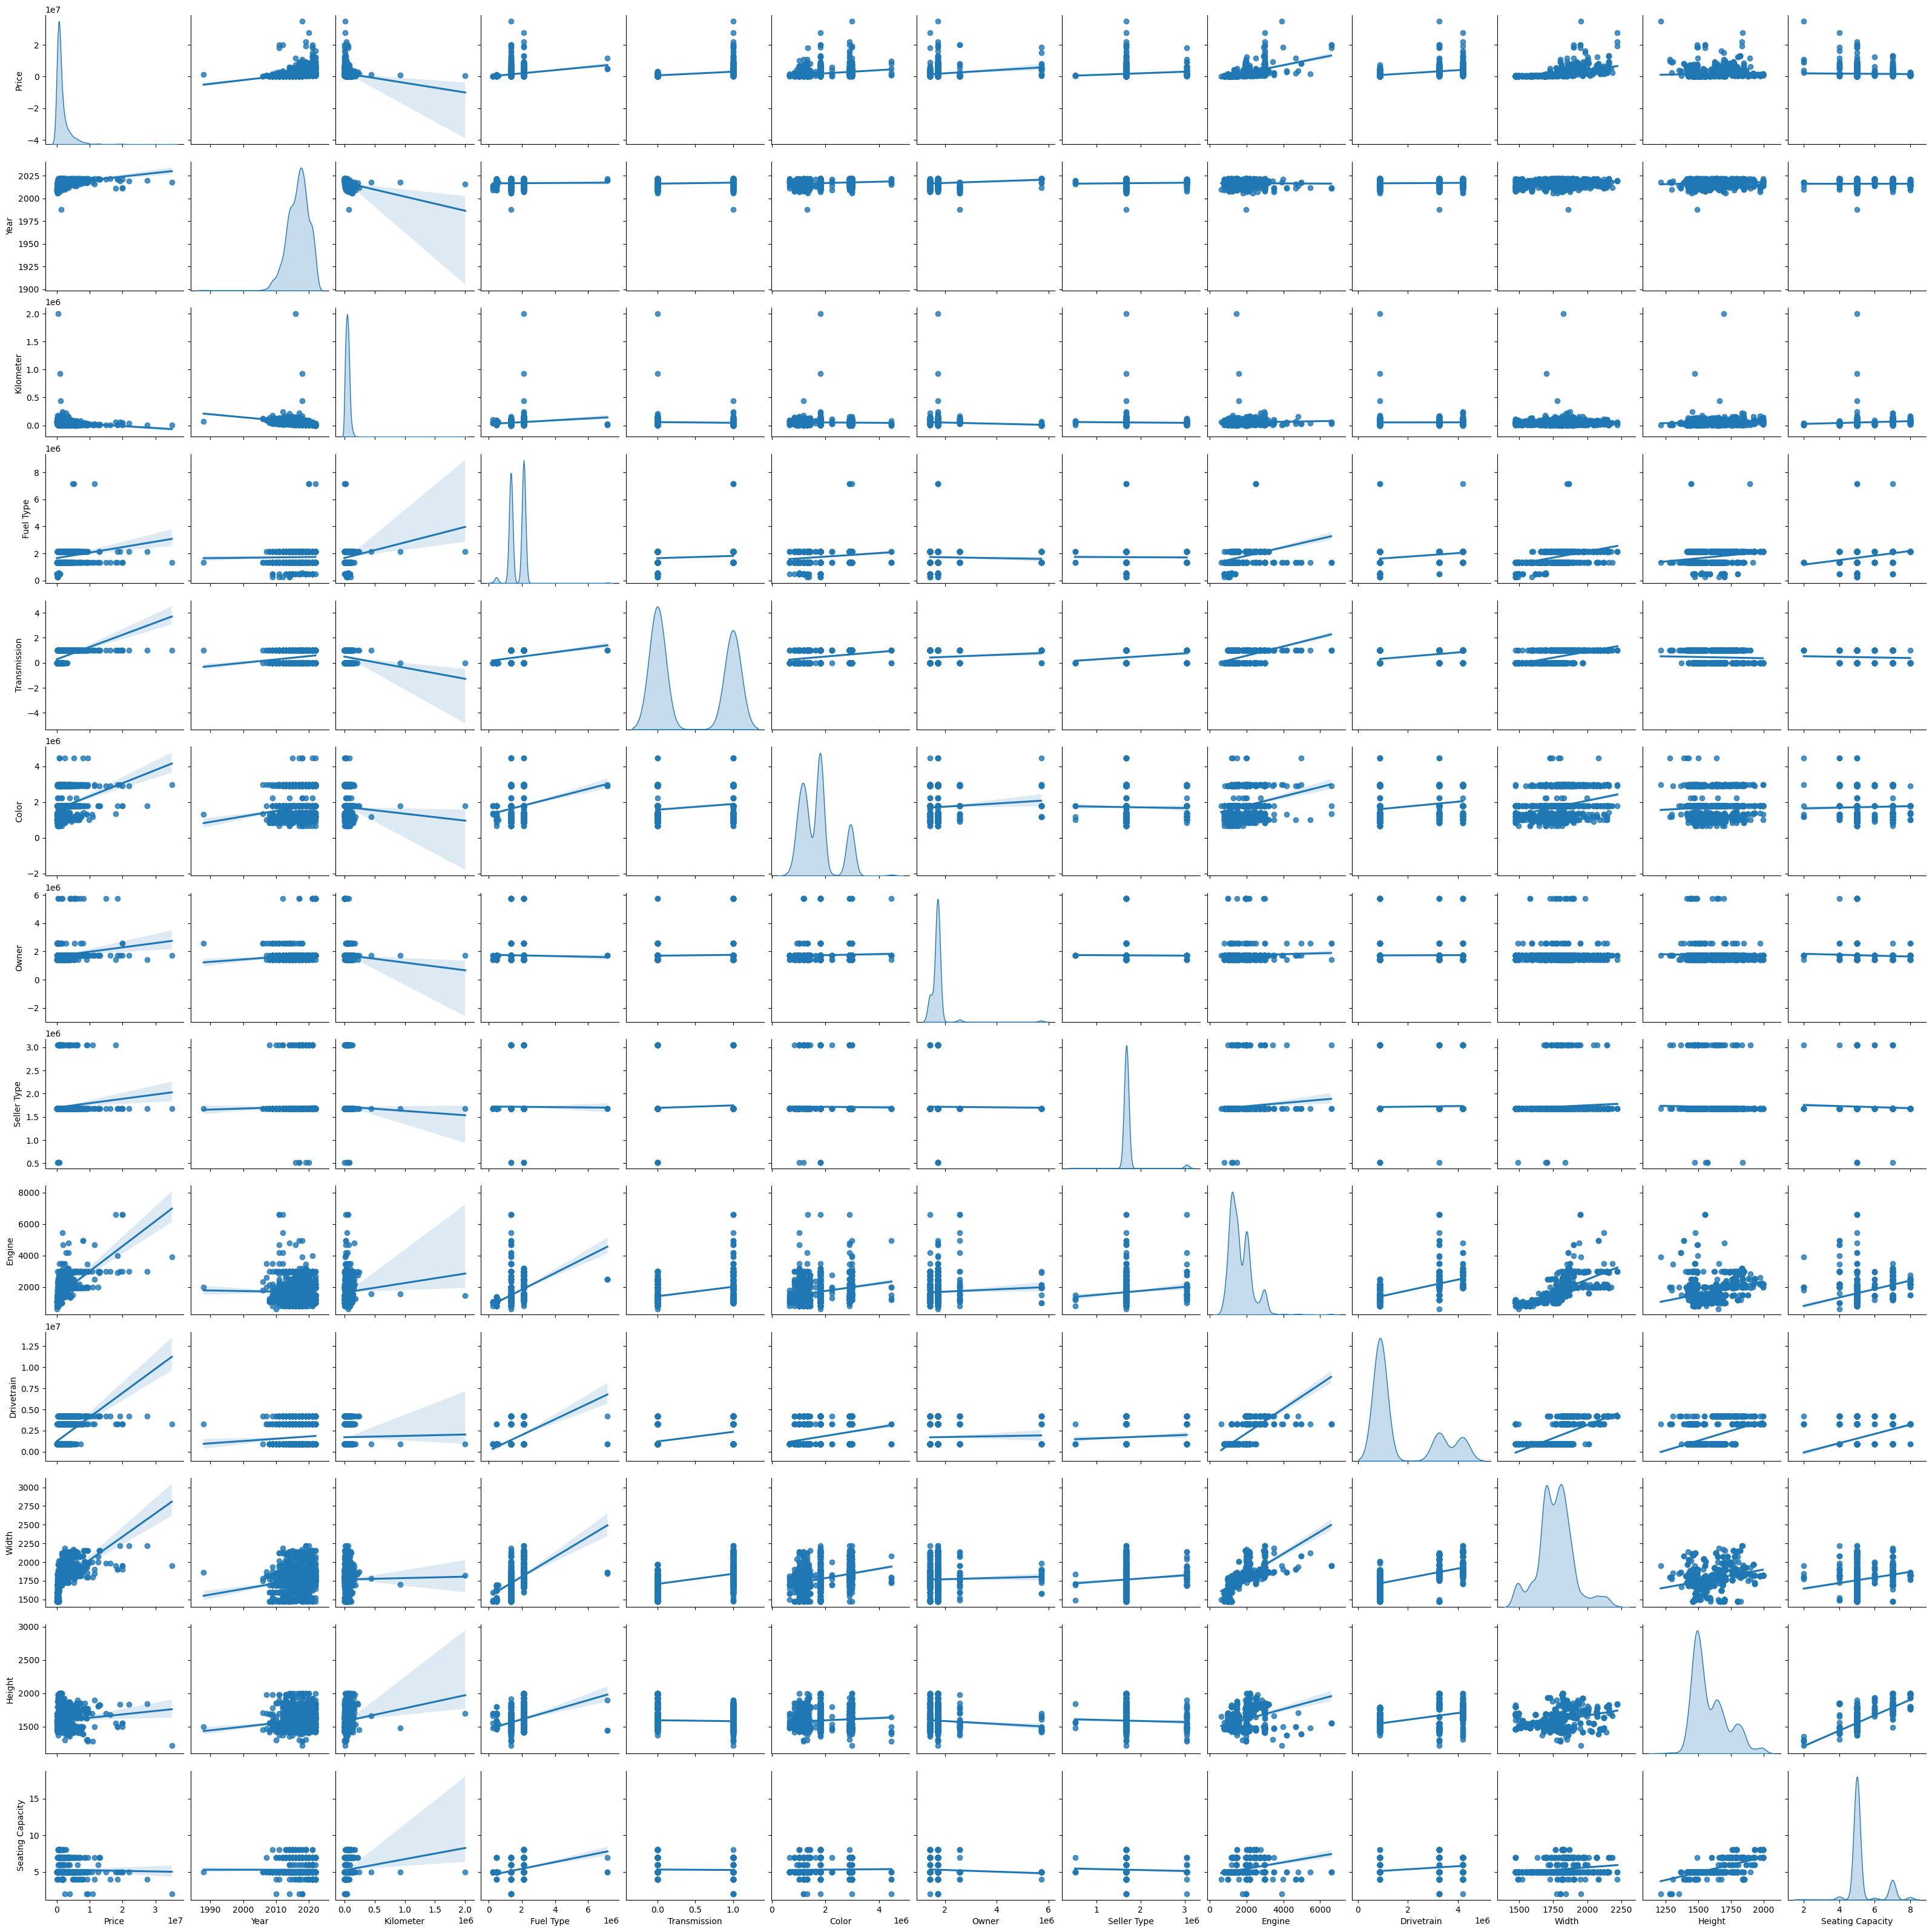

In [ ]:
sns.pairplot(df, kind='reg', markers='o', diag_kind='kde', height=2.5)
plt.show()

## i.	В случае подозрения на наличие выбросов, проверить так называемые важные наблюдения, которые значительно влияют на построение модели. 

In [ ]:
influence = OLSInfluence(est2)
influence = influence.results.get_influence()
influence.summary_frame()

,dfb_const,dfb_x1,dfb_x2,dfb_x3,dfb_x4,dfb_x5,dfb_x6,dfb_x7,dfb_x8,dfb_x9,dfb_x10,dfb_x11,dfb_x12,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
0,0.010024,-0.010292,0.002492,0.004538,-0.021675,0.012405,0.002730,0.004706,-0.005187,0.008925,0.008527,0.001067,-0.002954,0.000098,-0.563068,0.004005,-0.035703,-0.562939,-0.035695
1,0.034109,-0.034359,-0.021257,0.034122,0.002729,0.021938,0.012958,0.006232,-0.035553,-0.015755,-0.002274,-0.015741,0.075835,0.001036,1.363534,0.007195,0.116078,1.363929,0.116111
2,0.033135,-0.033248,0.003172,0.009637,-0.023461,0.021384,0.006797,0.008145,-0.007084,0.013017,0.003016,0.008069,-0.007449,0.000272,-0.799595,0.005505,-0.059492,-0.799498,-0.059485
3,0.011092,-0.010678,-0.001700,-0.006789,0.017945,-0.034886,-0.001774,-0.002528,0.004038,-0.021120,0.017555,-0.025030,-0.001290,0.000431,-0.718748,0.010721,-0.074823,-0.718631,-0.074811
4,0.006086,-0.007045,0.001060,-0.006485,0.000071,0.012662,0.001079,-0.003191,-0.022042,0.006938,0.030297,0.019229,-0.018948,0.000206,0.458202,0.012604,0.051769,0.458081,0.051755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1494,0.023432,-0.024216,0.010326,-0.031005,-0.014726,0.010897,0.004113,0.005688,0.013885,-0.053407,0.030512,-0.002317,0.021469,0.000531,-0.997736,0.006884,-0.083067,-0.997735,-0.083067
1495,0.027398,-0.025689,-0.013814,0.007691,-0.000072,0.001411,0.003589,0.001704,-0.001005,0.021944,-0.041475,-0.014601,0.008151,0.000424,0.963885,0.005895,0.074226,0.963862,0.074224
1496,0.002316,-0.002419,0.000838,-0.001521,-0.005474,0.001360,0.000339,0.000397,-0.000123,0.000233,0.005598,-0.001928,0.000567,0.000006,-0.087393,0.009285,-0.008461,-0.087363,-0.008458
1497,0.029312,-0.028609,0.005280,0.018769,0.024071,-0.001052,0.005048,0.004463,-0.010328,0.016092,-0.017501,-0.010987,0.012741,0.000246,-0.759819,0.005504,-0.056524,-0.759711,-0.056516


## j.	Используя функцию Step или StepAIC, постараться улучшить модель. 

In [ ]:
def forward_selection(X, y):
    selected_features = []
    remaining_features = set(X.columns)
    best_aic = np.inf

    while remaining_features:
        aic_values = []
        for feature in remaining_features:
            model = sm.OLS(y, sm.add_constant(X[selected_features + [feature]])).fit()
            aic = model.aic
            aic_values.append((feature, aic))

        best_feature, best_aic_candidate = min(aic_values, key=lambda x: x[1])

        if best_aic_candidate < best_aic:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            best_aic = best_aic_candidate
        else:
            break

    return selected_features            
            

In [ ]:
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print("prev AIC: ", est2.aic)

new_features = forward_selection(X, y)
new_X = df[new_features]

X2 = sm.add_constant(new_X)
est = sm.OLS(y, X2)
est2 = est.fit()
print("new AIC: ", est2.aic)

prev AIC:  58795.71395070393
new AIC:  58794.42930763407


## k.	В случае получения в предыдущем пункте модели, отличной от базовой, повторить пп. c-i для новой модели.

In [ ]:
X = df[new_features]

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values.reshape(-1), train_size=0.8)

reg = LinearRegression()

reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.46955333816043376

In [ ]:
X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     197.7
Date:                Mon, 27 Nov 2023   Prob (F-statistic):          1.76e-281
Time:                        11:12:19   Log-Likelihood:                -23341.
No. Observations:                1499   AIC:                         4.671e+04
Df Residuals:                    1487   BIC:                         4.677e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.055e+08   2.94e+07    -10.382      0.0

In [ ]:
f_test = est2.f_test("x1 = x2 = x3 = x4 = x5 = x6 = x7 = x8 = 0")
if f_test.pvalue < 0.05:
    result = 'Построение уравнения регрессии значимо в целом'
else:
    result = 'Построение уравнения НЕ регрессии значимо в целом'
print(f'F-test: {result:>21s}')
print(f_test.pvalue)

F-test: Построение уравнения регрессии значимо в целом
9.441276011889565e-178


## l.	Построить графики: scatterplot, "Residuals vs Fitted", "Normal Q-Q" , "Residuals vs Leverage" и дать интерпретации. 

c:\Users\CONDA\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


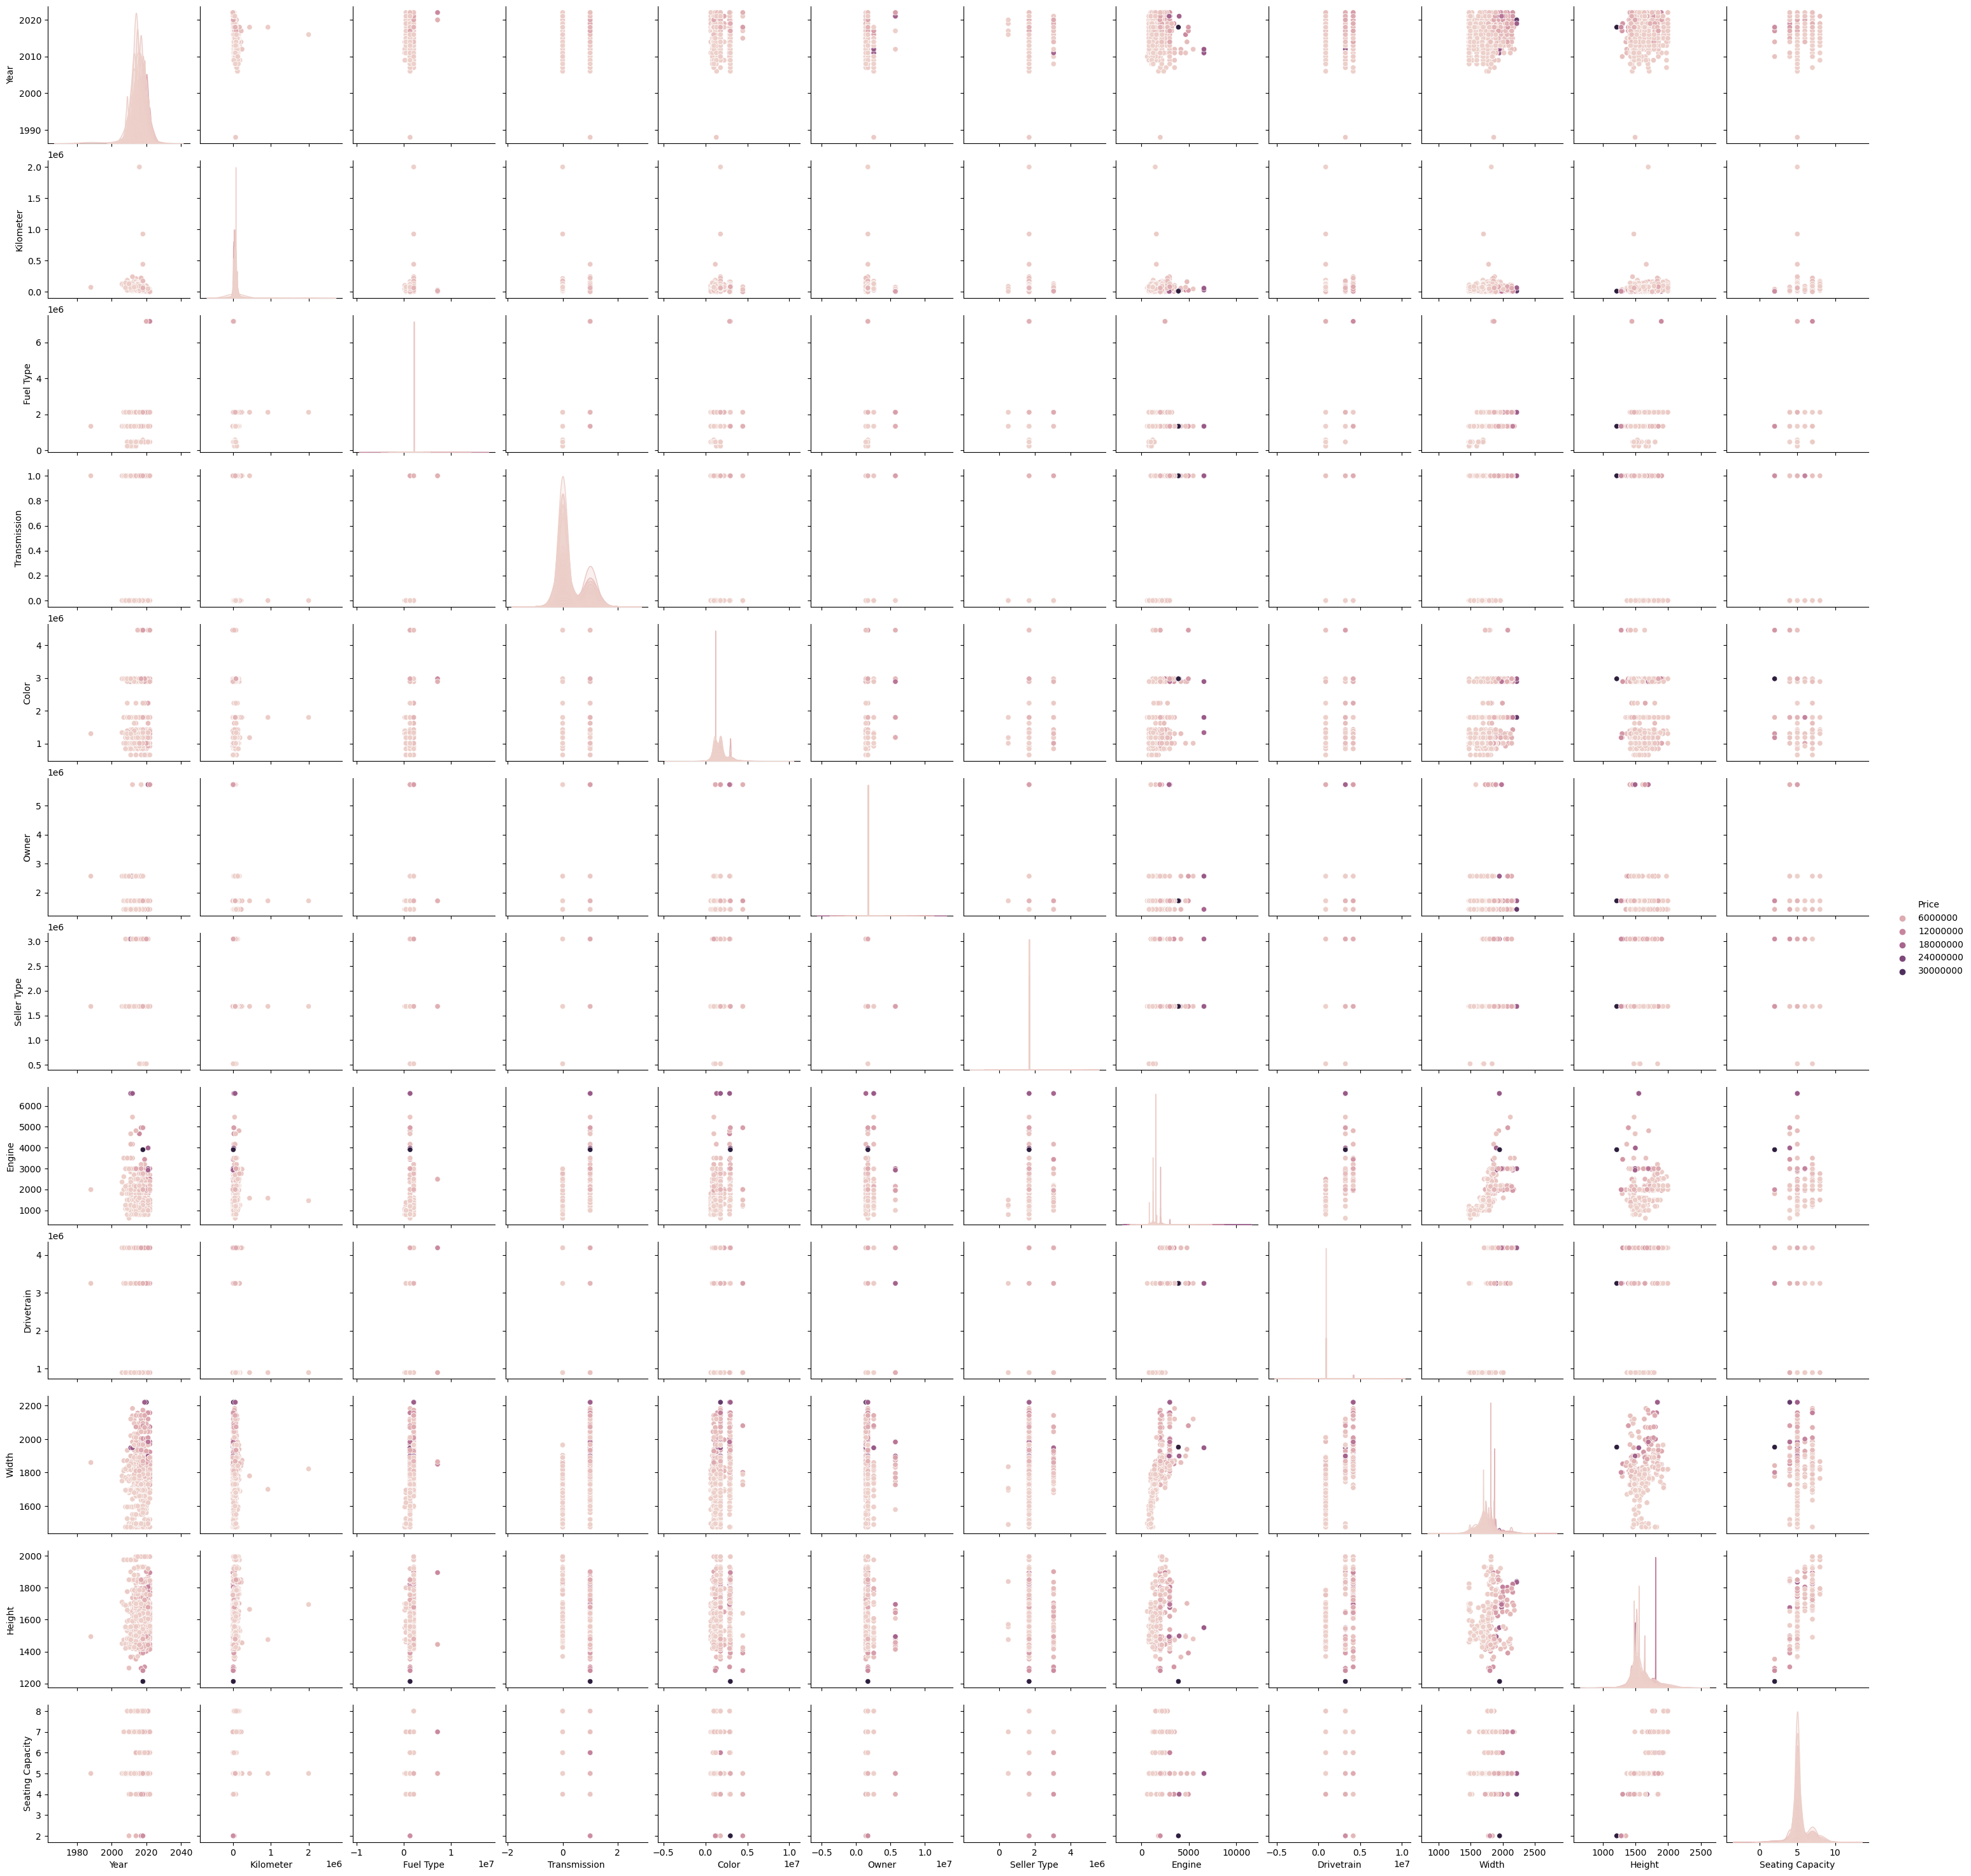

In [ ]:
sns.pairplot(df, diag_kind='kde', markers='o', hue='Price')
plt.show()

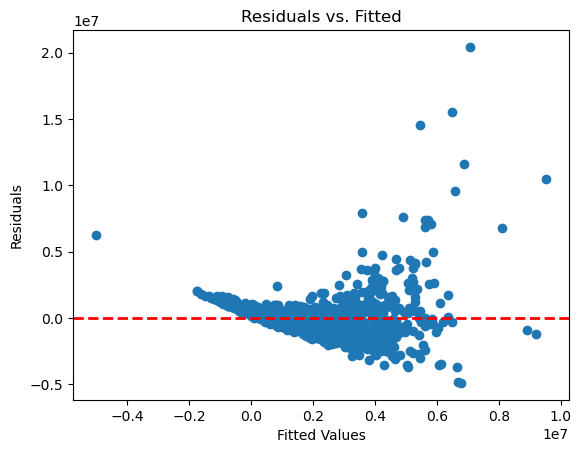

In [ ]:
model = sm.OLS(y_train, X_train).fit()

residuals = model.resid
fitted_values = model.fittedvalues

plt.scatter(fitted_values, residuals)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.title('Residuals vs. Fitted')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

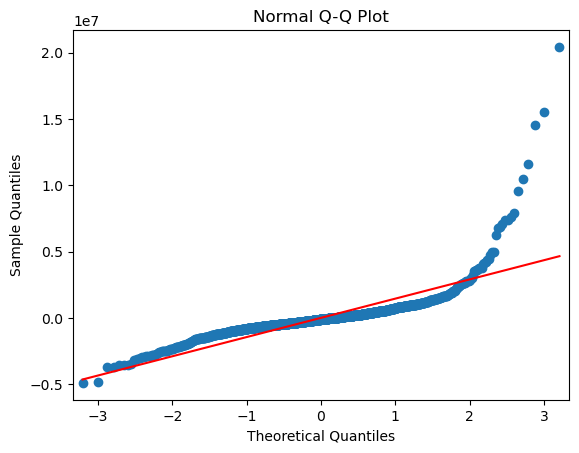

In [ ]:
sm.qqplot(residuals, line='s')
plt.title('Normal Q-Q Plot')
plt.show()

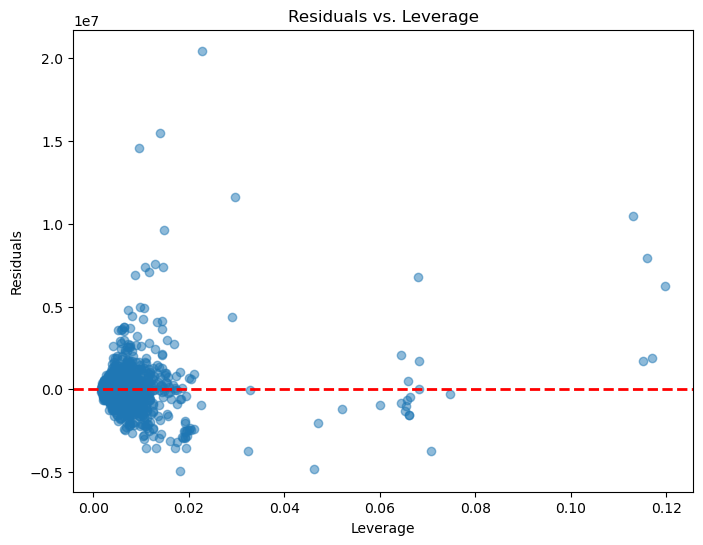

In [ ]:
leverage = OLSInfluence(model).hat_matrix_diag

plt.figure(figsize=(8, 6))
plt.scatter(leverage, residuals, alpha=0.5)
plt.title('Residuals vs. Leverage')
plt.xlabel('Leverage')
plt.ylabel('Residuals')
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.show()

## m.	Проверить модель на наличие выбросов. 

In [ ]:
model = sm.OLS(y, X).fit()

outlier_test_result = model.outlier_test()

print(outlier_test_result)

      student_resid   unadj_p  bonf(p)
0          0.130206  0.896417      1.0
1          0.181813  0.855750      1.0
2          0.086406  0.931153      1.0
3         -0.004160  0.996681      1.0
4          0.029486  0.976480      1.0
...             ...       ...      ...
1869       0.020736  0.983459      1.0
1870      -0.090104  0.928215      1.0
1871       0.671779  0.501808      1.0
1872      -0.076640  0.938918      1.0
1873       0.538464  0.590321      1.0

[1874 rows x 3 columns]


## n.	Проверить модель на гетероскедастичность.

In [ ]:
# mod_sm = sm.OLS(y, X)
# res_sm = mod_sm.fit()

# bp_lm, bp_lm_pvalue, bp_fvalue, bp_f_pvalue = sm.stats.diagnostic.het_breuschpagan(res_sm.resid, res_sm.model.exog)

name = ['F statistic', 'p-value']
test = sm.het_goldfeldquandt(model.resid, model.model.exog)
result = dict(zip(name, test))

print(result)

# if bp_lm_pvalue < 0.05:
#     print("Heteroscedasticity detected")
# else:
#     print("No heteroscedasticity detected")
# print("Breusch-Pagan test p-value:", bp_lm_pvalue)

AttributeError: module 'statsmodels.api' has no attribute 'het_goldfeldquandt'

## o.	Проверить остатки модели на автокорреляцию.

In [ ]:
durbin_watson_statistic = durbin_watson(residuals)

if durbin_watson_statistic < 2:
    result = 'negative autocorrelation'
else:
    result = 'negative autocorrelation'
print(f'Durbin-Watson test: {result:>21s}')
print(durbin_watson_statistic)

Durbin-Watson test: negative autocorrelation
1.9797497304145772


## p.	Проверить остатки модели на нормальность распределения. 

In [ ]:
jarque_bera_stat, p_value, skewness, kurtosis = sm.stats.jarque_bera(residuals)

if p_value < 0.05:
    result = 'normal distribution'
else:
    result = 'NOT normal distribution'
print(f'Jarque-Bera test: {result:>21s}')
print(kurtosis)

print("Jarque-Bera statistic:", jarque_bera_stat)

Jarque-Bera test:   normal distribution
68.71740702506283
Jarque-Bera statistic: 277463.9250859543


## q.	Проверить модель на мультиколлинеарность данных.

In [ ]:
def calculate_vif(data_frame):
    variables = data_frame.columns
    vif_data = pd.DataFrame()
    vif_data["Variable"] = variables
    vif_data["VIF"] = [sm.OLS(data_frame[variable],
                              sm.add_constant(data_frame.loc[:, data_frame.columns != variable])).fit().rsquared
                      for variable in variables]
    return vif_data

vif_results = calculate_vif(df[new_features])
print(vif_results)

            Variable       VIF
0             Engine  0.663891
1               Year  0.218324
2   Seating Capacity  0.521212
3         Drivetrain  0.616241
4              Owner  0.035822
5              Width  0.647053
6             Height  0.609676
7          Kilometer  0.121909
8          Fuel Type  0.294474
9              Color  0.126933
10      Transmission  0.417108


## r.	Попробовать применить трансформацию Box-Cox зависимой переменной.

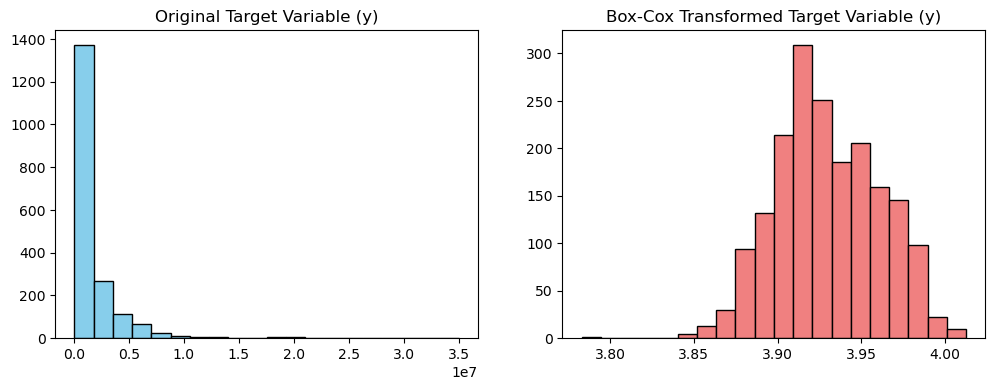

Optimal lambda for transformation of target variable y: -0.2457330379209304


In [ ]:
y = df['Price']
transformed_y, lambda_y = boxcox(y + 1) 
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(y, bins=20, edgecolor='black', color='skyblue')
plt.title('Original Target Variable (y)')

plt.subplot(1, 2, 2)
plt.hist(transformed_y, bins=20, edgecolor='black', color='lightcoral')
plt.title('Box-Cox Transformed Target Variable (y)')

plt.show()

print(f'Optimal lambda for transformation of target variable y: {lambda_y}')

## s.	В случае получения новой модели в предыдущем пункте проанализировать новую модель.

In [ ]:
X = df[new_features]

X_train, X_test, y_train, y_test = train_test_split(X.values, transformed_y.reshape(-1), train_size=0.8)

reg = LinearRegression()

reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.8935653286960373

In [ ]:
X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     1072.
Date:                Sun, 26 Nov 2023   Prob (F-statistic):               0.00
Time:                        23:25:05   Log-Likelihood:                 4715.8
No. Observations:                1499   AIC:                            -9408.
Df Residuals:                    1487   BIC:                            -9344.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.6738      0.190    -24.627      0.0

In [ ]:
f_test = est2.f_test("x1 = x2 = x3 = x4 = x5 = x6 = x7 = x8 = x9 = x10 = x11 = 0")
if f_test.pvalue < 0.05:
    result = 'Построение уравнения регрессии значимо в целом'
else:
    result = 'Построение уравнения НЕ регрессии значимо в целом'
print(f'F-test: {result:>21s}')
print(f_test.pvalue)

F-test: Построение уравнения регрессии значимо в целом
0.0


c:\Users\CONDA\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


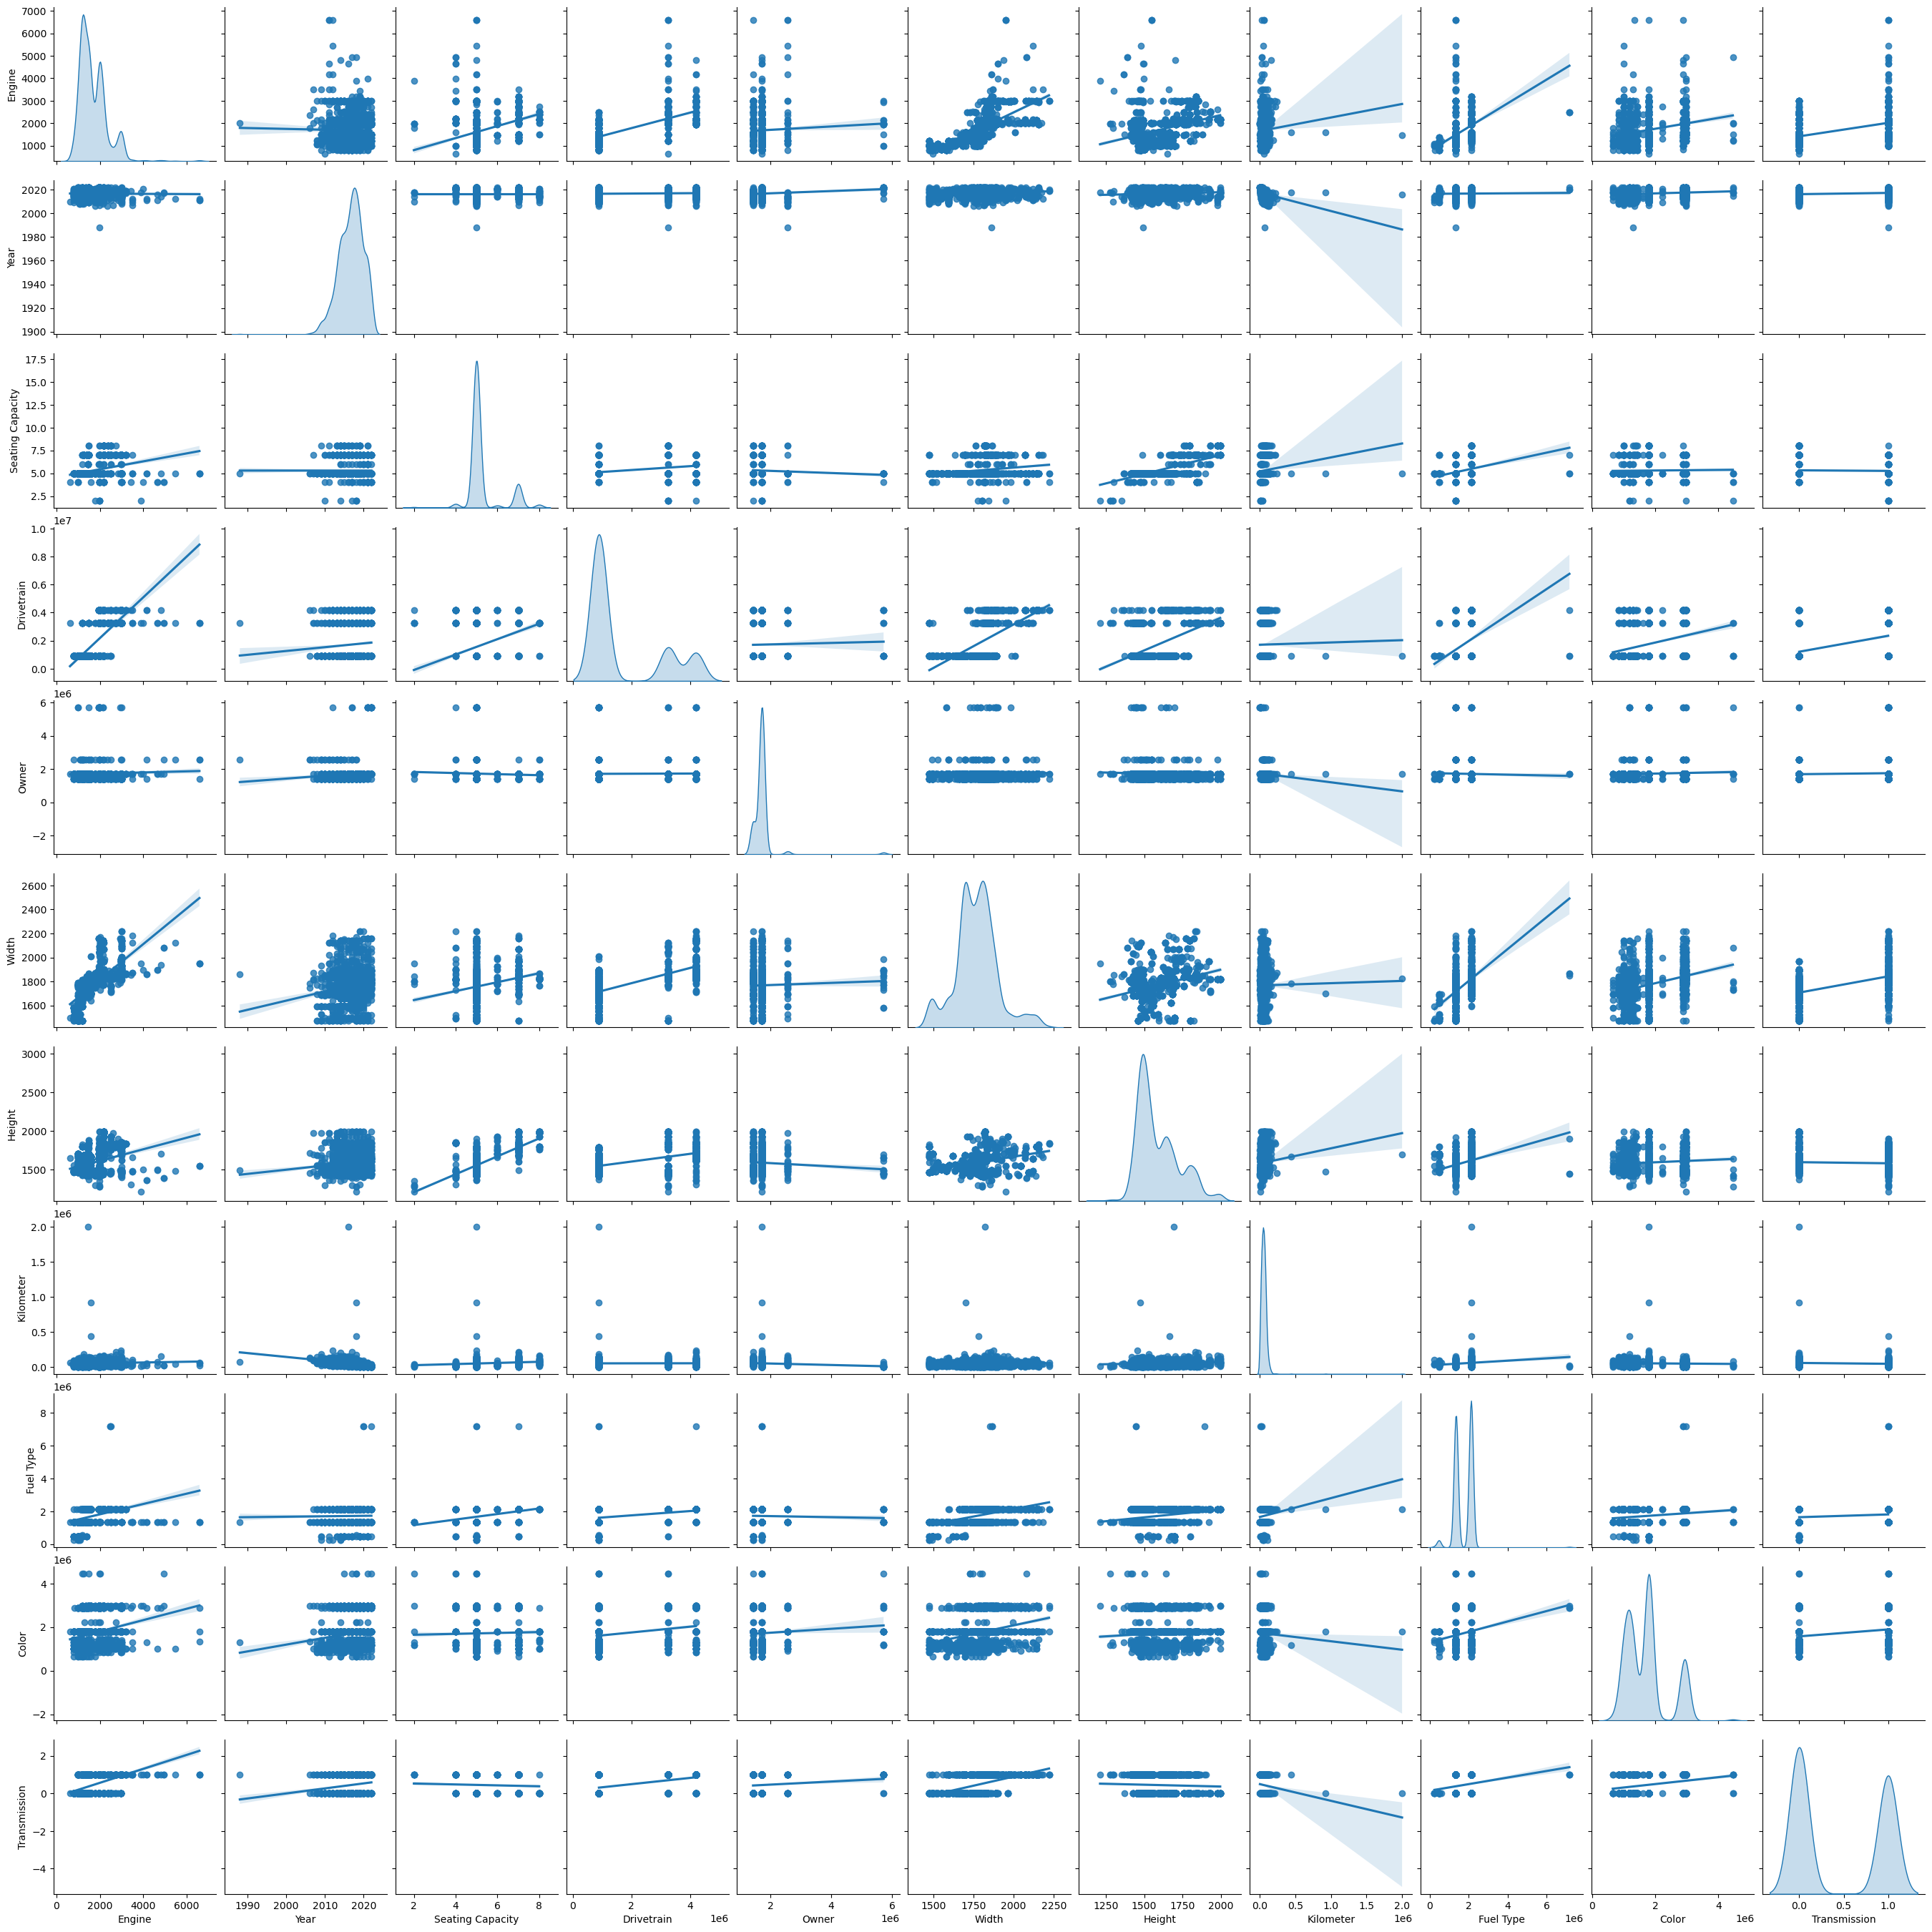

In [ ]:
sns.pairplot(df[new_features], kind='reg', markers='o', diag_kind='kde', height=2.5)
plt.show()

In [ ]:
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print("prev AIC: ", est2.aic)

new_features = forward_selection(X, y)
new_X = df[new_features]

X2 = sm.add_constant(new_X)
est = sm.OLS(y, X2)
est2 = est.fit()
print("new AIC: ", est2.aic)

prev AIC:  58794.42930763407
new AIC:  58794.42930763407


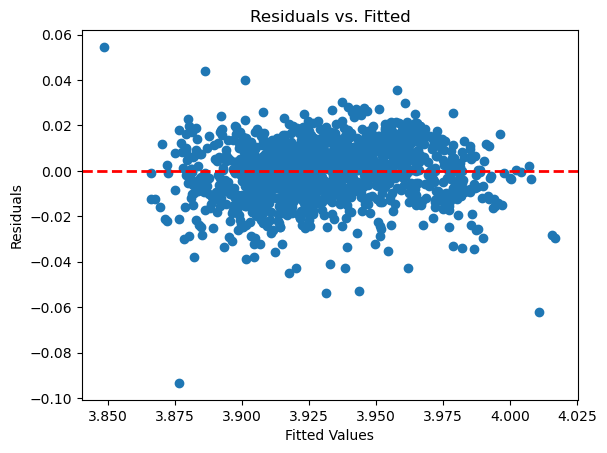

In [ ]:
model = sm.OLS(y_train, X_train).fit()

residuals = model.resid
fitted_values = model.fittedvalues

plt.scatter(fitted_values, residuals)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.title('Residuals vs. Fitted')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

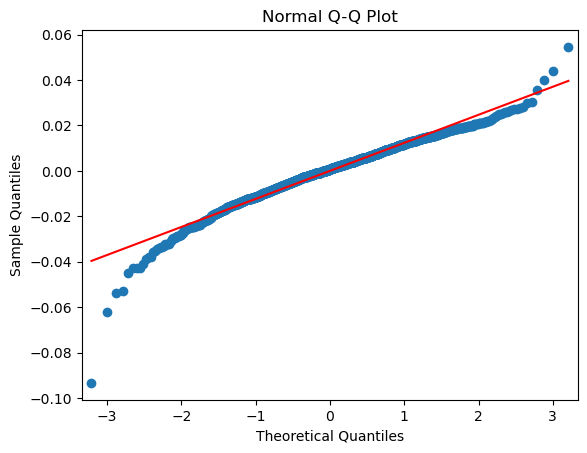

In [ ]:
sm.qqplot(residuals, line='s')
plt.title('Normal Q-Q Plot')
plt.show()

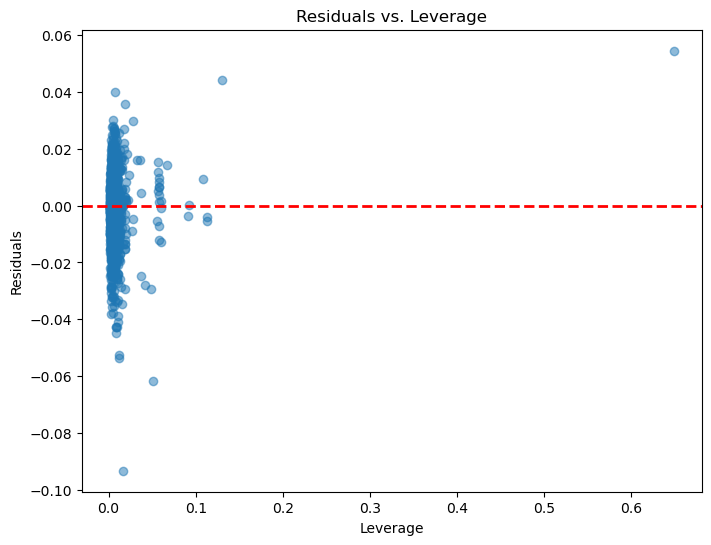

In [ ]:
leverage = OLSInfluence(model).hat_matrix_diag

plt.figure(figsize=(8, 6))
plt.scatter(leverage, residuals, alpha=0.5)
plt.title('Residuals vs. Leverage')
plt.xlabel('Leverage')
plt.ylabel('Residuals')
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.show()

In [ ]:
model = sm.OLS(y, X).fit()

outlier_test_result = model.outlier_test()

print(outlier_test_result)

      student_resid   unadj_p  bonf(p)
0          0.130206  0.896417      1.0
1          0.181813  0.855750      1.0
2          0.086406  0.931153      1.0
3         -0.004160  0.996681      1.0
4          0.029486  0.976480      1.0
...             ...       ...      ...
1869       0.020736  0.983459      1.0
1870      -0.090104  0.928215      1.0
1871       0.671779  0.501808      1.0
1872      -0.076640  0.938918      1.0
1873       0.538464  0.590321      1.0

[1874 rows x 3 columns]


In [ ]:
a, p_value, b, c = het_breuschpagan(model.resid, X)

if p_value < 0.05:
    result = 'дисперсии остатков различны'
else:
    result = 'дисперсии остатков одинаковы'
print("Breusch-Pagan test p-value:", p_value)
print(result)

ValueError: The Breusch-Pagan test requires exog to have at least two columns where one is a constant.

In [ ]:
durbin_watson_statistic = durbin_watson(residuals)

if durbin_watson_statistic < 2:
    result = 'negative autocorrelation'
else:
    result = 'negative autocorrelation'
print(f'Durbin-Watson test: {result:>21s}')
print(durbin_watson_statistic)

Durbin-Watson test: negative autocorrelation
2.0305542500137297


In [ ]:
jarque_bera_stat, p_value, skewness, kurtosis = sm.stats.jarque_bera(residuals)

if p_value < 0.05:
    result = 'normal distribution'
else:
    result = 'NOT normal distribution'
print(f'Jarque-Bera test: {result:>21s}')
print(p_value)

Jarque-Bera test:   normal distribution
2.0803131694479166e-179
Jarque-Bera statistic: 822.8604264026395


In [ ]:
def calculate_vif(data_frame):
    variables = data_frame.columns
    vif_data = pd.DataFrame()
    vif_data["Variable"] = variables
    vif_data["VIF"] = [sm.OLS(data_frame[variable],
                              sm.add_constant(data_frame.loc[:, data_frame.columns != variable])).fit().rsquared
                      for variable in variables]
    return vif_data

vif_results = calculate_vif(df[new_features])
print(vif_results)

            Variable       VIF
0             Engine  0.663891
1               Year  0.218324
2   Seating Capacity  0.521212
3         Drivetrain  0.616241
4              Owner  0.035822
5              Width  0.647053
6             Height  0.609676
7          Kilometer  0.121909
8          Fuel Type  0.294474
9              Color  0.126933
10      Transmission  0.417108
